## Gibbs sampling to estimate copy number distribution across DMD exons

In [307]:
import pysam
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns

%matplotlib inline

In [283]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
# had to make local change in utilities 
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200, include_index=True)
exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged] # this exon label gets used later

Finished loading the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.25 sec


In [3]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference)
EXON46 = [31950197, 31950344]
EXON47 = [31947713, 31947862]
EXON48 = [31893308, 31893490]
EXON49 = [31854835, 31854939]
EXON50 = [31838092, 31838200]
EXON51 = [31792077, 31792309]
DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]

2702


In [4]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Control data -- exon intensities

In [219]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=1, index_col=0)
coverage_df.index.name = None
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified)
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
coverage_df_M1_f = coverage_df_f[coverage_df_f.sequencer == 'M1']
coverage_df_T1_f = coverage_df_f[coverage_df_f.sequencer == 'T1']
print coverage_df.shape
coverage_df.head()

(1266, 88)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,102,42,76,55,139,44,30,71,12,81
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,85,60,77,38,121,40,52,71,14,67
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,143,45,76,37,137,37,33,74,6,38
4,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,152,32,96,51,117,29,32,79,9,56
5,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,1970-01-01 00:00:01.465400971,...,36,22,48,64,64,36,44,10,1,6


In [221]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
def reshape_df(df, include_stats=False, subject_droplist=None, df_counts_wanted=False):
    if 'date_modified' in df.columns:
        df.drop('date_modified', axis=1, inplace=True)
    df_grouped = df.groupby(['subject']).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    if df_counts_wanted:
        return df_norm, df_grouped
    else:
        return df_norm

In [222]:
# use RMA samples for initial intensity vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
RMA_norm = reshape_df(coverage_df_RMA, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs

['M1']
78


array([ 0.04589008,  0.00181261,  0.0111598 ,  0.01918853,  0.01104113,
        0.0166613 ,  0.0166843 ,  0.01212952,  0.00371631,  0.01597643,
        0.01188   ,  0.00994347,  0.00875295,  0.00676731,  0.0183255 ,
        0.007394  ,  0.00961452,  0.00514529,  0.01048072,  0.02985736,
        0.01276754,  0.01643603,  0.01196839,  0.00946219,  0.02820376,
        0.01037773,  0.02059615,  0.0089391 ,  0.01577857,  0.00666614,
        0.009583  ,  0.00995351,  0.02010135,  0.00837557,  0.01176132,
        0.0112656 ,  0.01252437,  0.00844386,  0.01113459,  0.01235549,
        0.01049119,  0.0076502 ,  0.01632141,  0.01293299,  0.02815898,
        0.00908641,  0.0234396 ,  0.01244374,  0.0216019 ,  0.00885256,
        0.01000741,  0.00725296,  0.02025866,  0.00825177,  0.02257343,
        0.00719029,  0.00731126,  0.00843966,  0.01311383,  0.02040325,
        0.00818417,  0.01599219,  0.00793946,  0.01305769,  0.02064807,
        0.01183257,  0.01847446,  0.00963051,  0.01236458,  0.00

## Gibbs Sampling


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ z = \{1,2,3\}$. 

We also know "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 

This generates probability values for the multinomial distribution from which we will sample the reads for a single simulated "sequencing run". When testing a real subject's data, we still use the known $\mathbf{X}$ but use data $Y$ from the subject.

Initialize the intensities $\mathbf{X}$ (see X_probs above). Initialize $c_i$ values based on basic prior distribution. Assume 5000 reads per sample/subject and initialize a single sequencing run $Y = \{y_1, y_2, ... y_{78}\}$. 

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_j^t}(c) = \dfrac{\Pi_j (p_j|c_i=c)^{y_j}}{\sum_c \Pi_j (p_j|c_i=c)^{y_j}} $$ 
where $$ C_j^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$

Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial constant). 

**Implementation considerations**: $\Pi_j (p_j|c_i=c)^{y_j}$ can cause under/overflow in Python (or washout of values too close to 0), but trying to use the log of the posterior distribution leads to 
$$  \sum y_j \log (p_j|c_i=c) - \log \sum \Pi_j (p_j|c_i=c)^{y_j}$$

**Solution**: Convert to log space and divide by the maximal likelihood to normalize (and keep values from shrinking too close to 0):
$$ \dfrac{\exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}{\sum_c \exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}$$ 


### Next Steps
* Incorporate more complex and representative prior for the copy number distribution (in particular, there should be higher prior probability for 2 copies of exon)
* Determine more accurate estimate of burn-in period (fix log-likelihoods, should converge as iterations increase)
* Account for increased likelihood of copy number correlation between neighboring exons
* Consider modifying prior for two exon deletion hotspots (around 45-50 and 18-20)
* Incorporate step for correcting for mixin-based discrepancies
* Change intensity distribution to account for the fact that increasing coverage at one exon will slightly decrease coverage at other exons

In [250]:
def generate_gibbs_df(cnv_support, X_probs, data=None, cnv=None, total_reads=5000, iterations=10000, burn_in=1000):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)'''
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(X_probs)) 
    print cnv 
    normed_probs_first = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs))
    if data is None:
        data = np.random.multinomial(total_reads, normed_probs_first)
    gibbs_data = np.zeros((len(X_probs), iterations))
    
    likelihoods = np.zeros(iterations)
    for i in range(iterations):
        if (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        for exon in range(len(X_probs)):
            test = np.zeros(len(cnv_support))
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value
                normed_probs_test = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs)) 
                log_likelihood =  np.sum(np.multiply(np.log(normed_probs_test), data))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
            cnv[exon] = new_cnv
            gibbs_data[exon, i] = new_cnv
        log_probs = np.log(np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs)))
        likelihoods[i] = np.sum(np.multiply(log_probs, data))
    
    # get proportions using burn-in of 1000 iterations 
    gibbs_data_results = np.zeros((len(X_probs), len(cnv_support)))
    for index in range(len(X_probs)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        gibbs_slice = gibbs_data[index][burn_in:][::100]
        gibbs_data_results[index] = np.bincount(gibbs_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(len(gibbs_slice))
    
    gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support]).reset_index()
    gibbs_df.rename(columns={'index': 'Exon'}, inplace=True)
    gibbs_df.Exon = gibbs_df.Exon + 1
    
    return gibbs_data, gibbs_data_results, likelihoods, gibbs_df

In [251]:
cnv_support = [1,2,3]
gibbs_data2, gibbs_data_results2, logliks, gibbs_df2 = generate_gibbs_df(cnv_support, X_probs, total_reads=5000, 
                                                                        iterations=10000)

[2 2 2 2 1 3 3 2 1 2 1 3 3 1 3 2 1 2 3 2 1 3 3 1 2 2 3 1 1 1 3 2 3 1 2 1 3
 1 3 3 1 2 1 2 3 1 1 2 1 3 2 3 3 1 3 3 3 2 2 3 3 3 1 3 1 3 3 3 2 2 1 1 2 3
 3 1 1 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [252]:
gibbs_df2.head(10)

,Exon,copy_1,copy_2,copy_3
0,1,0.000000,1.000000,0.000000
1,2,0.366667,0.522222,0.111111
2,3,0.000000,0.855556,0.144444
3,4,0.000000,1.000000,0.000000
4,5,1.000000,0.000000,0.000000
5,6,0.000000,0.000000,1.000000
6,7,0.000000,0.011111,0.988889
7,8,0.000000,1.000000,0.000000
8,9,0.822222,0.177778,0.000000
9,10,0.000000,1.000000,0.000000


In [269]:
# trying to figure out why the log-likelihoods don't seem to increase significantly
cnv9000 = gibbs_data2[:,9000]
cnv9100 = gibbs_data2[:,9100]
cnv9200 = gibbs_data2[:,9200]
cnv9300 = gibbs_data2[:,9300]
print cnv9000 == cnv9100
print cnv9100 == cnv9200
print cnv9200 == cnv9300

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True False  True  True  True  True
  True False False  True  True  True]
[ True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True  True False  True  True  True  True  True  True
  True False  True  True  True  True]
[ True False  True  True  True  True  True  True

[-20588.85187458 -20587.90233702 -20590.02351235 -20585.44453171
 -20587.79933716 -20588.6450237  -20587.16716169 -20584.54174261
 -20593.18970537 -20585.65857471]
[-20593.4962198  -20587.63112981 -20591.03008159 -20587.3911948
 -20586.35380999 -20591.08132329 -20589.63450924 -20586.57994475
 -20593.51861308 -20588.83879327]


<function matplotlib.pyplot.show>

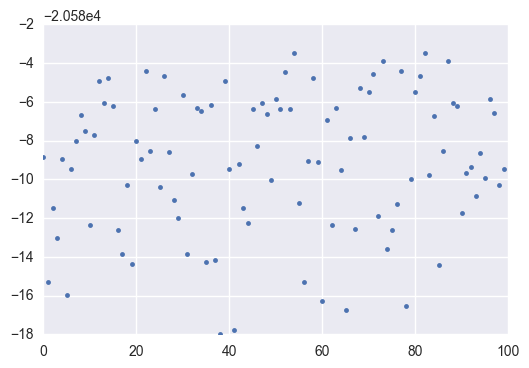

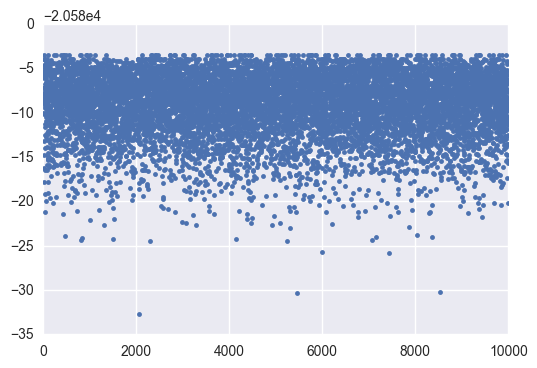

In [260]:
print logliks[:10]
print logliks[9990:]
# why don't likelihoods converge as iterations continue?
plt.figure()
plt.plot(range(len(logliks[::100])), logliks[::100], '.')
# plt.hist(logliks, bins=150)
plt.figure()
plt.plot(range(len(logliks)), logliks, '.')
plt.show

## Gibbs Sampling with simulated deletion data (with real subject templates)

### Getting and cleaning subject data

In [289]:
simulated_muts = ['FPWB-0000-822R_4850_delPEM', 'FGPC-4ZPF-J0F1_1619_delPEM', 'FGPC-0000-444F_30_dupPEM']

# using Max's code to build coverage matrix from test subject bamfile
base_headers = ['subject', 'specimen', 'sample', 'gender', 'sequencer', 'flow_cell_id', 'lane']
coverage_matrix = [base_headers + exon_labels]
subject_coverages = {}
for filename in simulated_muts:
    file_path = '../bams/{}.bam'.format(filename)
    bamfile = pysam.AlignmentFile(file_path, "rb")
    for RG in bamfile.header['RG']:
        subject, specimen_sample, flow_cell_lane = RG['ID'].split('_')
        gender = subject[0]
        specimen_num, sequencer, sample = specimen_sample.split('-')
        specimen = '{}_{}'.format(subject, specimen_num)
        sample = '{}_{}'.format(subject, specimen_sample)
        flow_cell_id, lane = flow_cell_lane.rsplit('-', 1)
        row = [subject, specimen, sample, gender, sequencer, flow_cell_id, lane]
        subject_coverages[RG['ID']] = row + [0] * len(DMD_exons_merged)

    for read in bamfile.fetch('X', start=31137345, end=33229636):
        if not read.is_unmapped and read.mapping_quality == 60:
            # Find what exon each read falls in, and increase that exon's coverage by 1
            interval_info = util.in_interval(read.reference_start, DMD_exons_merged, get_interval=True)
            if not interval_info[0]:
                # If the start of the read is not in an exon, check the end of the read
                interval_info = util.in_interval(read.reference_end, DMD_exons_merged, get_interval=True)
            if interval_info[0]:
                exon_num = interval_info[1]
                subject_coverages[read.get_tag('RG')][exon_num + len(base_headers)] += 1

coverage_matrix += subject_coverages.values()
coverage_matrix = np.array(coverage_matrix)

In [290]:
test_subjects = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
test_subjects_num = test_subjects.apply(lambda x: pd.to_numeric(x, errors='ignore'))
test_subjects_num.head()

,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,Ex1,Ex2,Ex3,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
0,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_1,FGPC-4ZPF-J0F1_1-M1-1,F,M1,H7MWWAFXX,L002,379,6,82,...,72,36,106,67,125,52,34,95,23,112
1,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L004,519,25,116,...,163,73,161,108,210,109,57,123,31,120
2,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_1,FGPC-4ZPF-J0F1_1-M1-1,F,M1,H7MWWAFXX,L004,454,10,88,...,80,54,125,62,118,43,29,104,24,118
3,FPWB-0000-822R,FPWB-0000-822R_1,FPWB-0000-822R_1-M1-1,F,M1,H753VAFXX,L004,767,22,174,...,214,84,170,110,223,104,61,144,38,200
4,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L002,609,22,161,...,179,64,176,115,181,98,55,160,33,149


In [291]:
subject_norm, subject_counts = reshape_df(test_subjects_num, df_counts_wanted=True)

In [292]:
subject_norm.head()

subject,Exon,FGPC-0000-444F,FGPC-4ZPF-J0F1,FPWB-0000-822R
0,Ex1,0.043581,0.053383,0.050346
1,Ex2,0.001981,0.001068,0.001113
2,Ex3,0.010309,0.010359,0.010960
3,Ex4,0.016617,0.016543,0.017552
4,Ex5,0.011366,0.012237,0.010403


In [293]:
subject_counts.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F,2266,103,536,864,591,714,906,615,240,681,...,659,257,729,449,847,384,233,576,137,552
FGPC-4ZPF-J0F1,1649,33,320,511,378,554,488,364,141,445,...,347,164,442,266,466,214,119,370,83,446
FPWB-0000-822R,2986,66,650,1041,617,1150,988,705,235,921,...,799,327,758,398,990,365,274,665,146,696


In [302]:
for i in range(len(subject_counts)):
    print '{} total reads: {}'.format(subject_counts.index[i], np.sum(np.array(subject_counts.iloc[i])))

FGPC-0000-444F total reads: 51995
FGPC-4ZPF-J0F1 total reads: 30890
FPWB-0000-822R total reads: 59309


In [300]:
subject_data = np.array(subject_counts.loc['FPWB-0000-822R'])
print subject_data
subject_data_half = subject_data / 2
subject_data_sixth = subject_data / 6

[2986   66  650 1041  617 1150  988  705  235  921  610  524  498  355 1085
  498  661  295  610 1716  798  907  776  590 1622  648 1149  500  984  421
  541  648 1263  538  741  717  802  501  689  761  654  561  944  860 1775
  585 1372  360  630  222  553  394 1159  508 1214  424  470  486  775 1322
  530  990  556  796 1346  762 1233  603  799  327  758  398  990  365  274
  665  146  696]


In [301]:
subject_data_del16 = np.array(subject_counts.loc['FGPC-4ZPF-J0F1'])
subject_data_dup30 = np.array(subject_counts.loc['FGPC-0000-444F'])

## Running Gibbs Sampler (simulated deletion 48-50), subject FPWB-0000-822R

We run the Gibbs sampler on a subject with a simulated deletion in exons 48-50. We continue to use the female RMA mean exon coverage ratios as our known exon intensity vector (note that this subject was not an RMA subject). Both the RMA samples and this subject's samples were run using a mix-in panel (M1). The sampler is seeded with a probable expected cnv vector (all copy numbers initialized to 2 -- see df_822R) and a randomly generated cnv vector (see df_822R2). As expected, this did not affect the final probability averages. This subject has a very large number of reads (~60k), so we also simulate an analogous subject with half and 1/6th the total coverage (see df_822R3, df_822R4). As expected, this generated more uncertainty in the final results.

In [214]:
norm_start = 2 * np.ones(78).astype(np.int64)

In [238]:
# with norm (most probable) starting cnv distribution
cnv_support = [1,2,3]
norm_start = 2 * np.ones(78).astype(np.int64)
gibbs_data_822R, gibbs_data_results_822R, logliks_822R, gibbs_df_822R = generate_gibbs_df(cnv_support, 
                                                                        X_probs, cnv=norm_start, data=subject_data, 
                                                                        iterations=10000)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [230]:
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822R2, gibbs_data_results_822R2, logliks_822R2, gibbs_df_822R2 = generate_gibbs_df(cnv_support, 
                                                                        X_probs, data=subject_data, 
                                                                        iterations=10000)

[2 2 1 2 2 1 1 2 3 2 3 2 2 3 1 2 2 2 2 1 2 1 2 2 2 1 2 3 1 1 3 3 2 1 3 2 3
 2 3 1 2 1 3 2 1 3 2 1 2 1 3 1 3 1 3 1 3 1 2 3 3 3 1 2 3 3 2 2 3 2 3 1 3 2
 2 1 1 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
90


In [239]:
# with norm starting cnvs and half the subject's original coverage
cnv_support = [1,2,3]
norm_start = 2 * np.ones(78).astype(np.int64)
gibbs_data_822R3, gibbs_data_results_822R3, logliks_822R3, gibbs_df_822R3 = generate_gibbs_df(cnv_support, 
                                                                        X_probs, cnv=norm_start, 
                                                                        data=subject_data_half, 
                                                                        iterations=10000)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [240]:
# with random starting cnvs and one sixth the subject's original coverage
cnv_support = [1,2,3]
gibbs_data_822R4, gibbs_data_results_822R4, logliks_822R4, gibbs_df_822R4 = generate_gibbs_df(cnv_support, 
                                                                        X_probs,  
                                                                        data=subject_data_sixth, 
                                                                        iterations=10000)

[2 1 1 3 2 1 3 1 2 2 2 1 3 1 3 3 2 3 2 3 2 2 2 2 1 1 3 2 3 2 3 2 2 3 2 3 1
 2 2 2 1 2 2 2 2 1 3 1 2 1 3 3 2 2 3 3 1 1 1 3 1 3 1 2 2 1 1 2 1 2 1 1 1 2
 3 1 1 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


10000


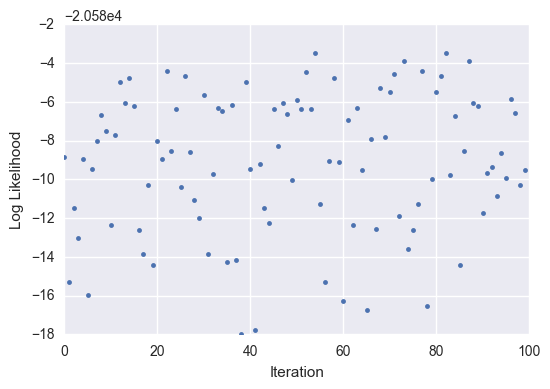

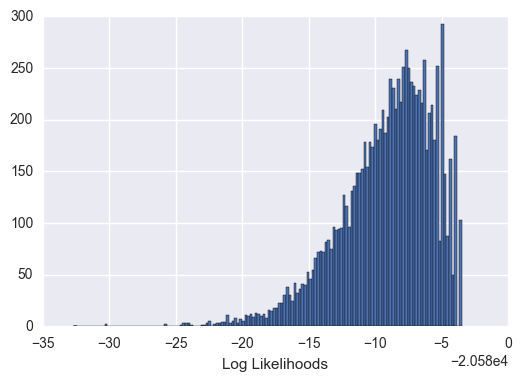

In [267]:
# again, no convergence?? has it already mostly converged?
plt.figure()
plt.plot(range(len(logliks_822R[::100])), logliks[::100], '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')
plt.figure()
plt.hist(logliks, bins=150)
plt.xlabel('Log Likelihoods')
print len(logliks_822R)

In [217]:
# reference: http://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html
def create_stacked_bars(df, title): 
    f, ax = plt.subplots(1, figsize=(10,5))
    bar_width = 1

    bar_l = [i for i in range(len(df['copy_1']))] 
    tick_pos = [i + bar_width for i in bar_l] 

    # loop through these later
    # Create a bar chart in position bar_1
    ax.bar(bar_l, df.copy_1, label='1 Copy', alpha=0.9, color='#019600', width=bar_width, edgecolor='white')

    ax.bar(bar_l, df.copy_2, bottom=df.copy_1, label='2 Copy', alpha=0.9, color='#3C5F5A', width=bar_width,
           edgecolor='white')

    ax.bar(bar_l, df.copy_3, bottom=[i+j for i,j in zip(df.copy_1, df.copy_2)], label='3 Copy',
           alpha=0.9, color='#219AD8', width=bar_width, edgecolor='white')

    plt.xticks(tick_pos, df['Exon'])
    ax.set_ylabel("Probabilities")
    ax.set_xlabel("Exons")

    plt.xlim([min(tick_pos)-2*bar_width, max(tick_pos)+bar_width])
    plt.ylim(-0.1, 1.1)

    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
               fancybox=True, shadow=True, ncol=3)
    plt.title(title)
    plt.show()

## Visualizing Results

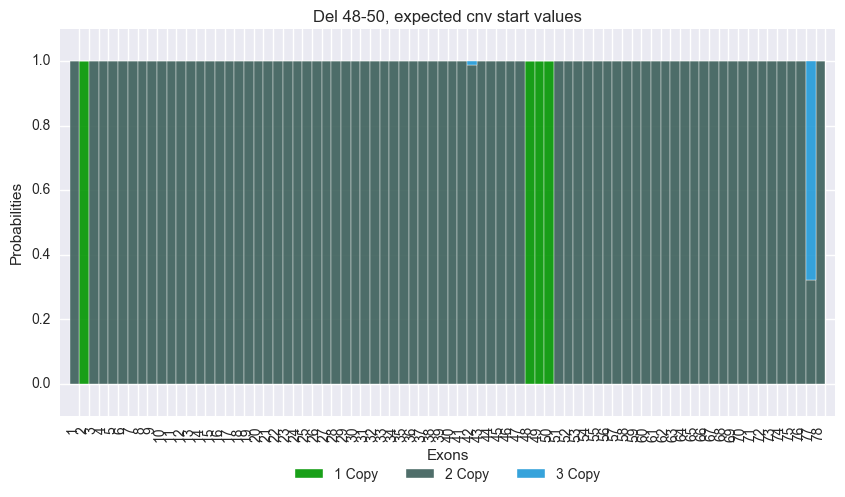

In [241]:
# note that this subject has a simulated deletion in exons 48-50 -- Gibbs sampler run with normed start values
create_stacked_bars(gibbs_df_822R, 'Del 48-50, expected cnv start values')

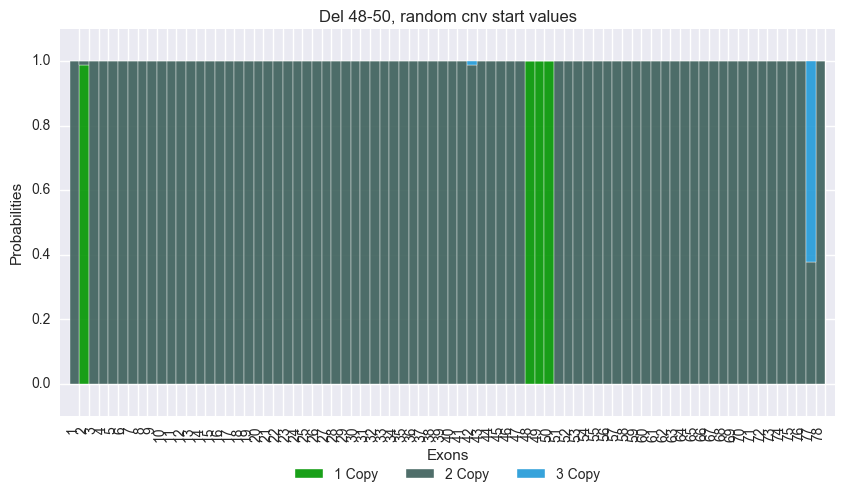

In [242]:
# note that this subject has a simulated deletion in exons 48-50 -- Gibbs sampler run with random start values
create_stacked_bars(gibbs_df_822R2, 'Del 48-50, random cnv start values')

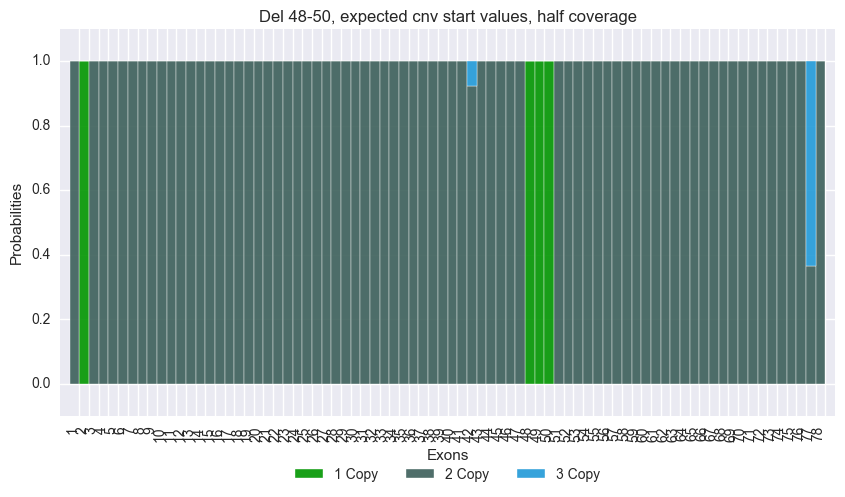

In [243]:
# note that this subject has a simulated deletion in exons 48-50 
create_stacked_bars(gibbs_df_822R3, 'Del 48-50, expected cnv start values, half coverage')

Poor coverage of exons 2 and 78 has likely led to increased probabilities of abnormal copy numbers in these exons. Note that exon 65 is actually 65 and 66, so later exon labels are 1 off.

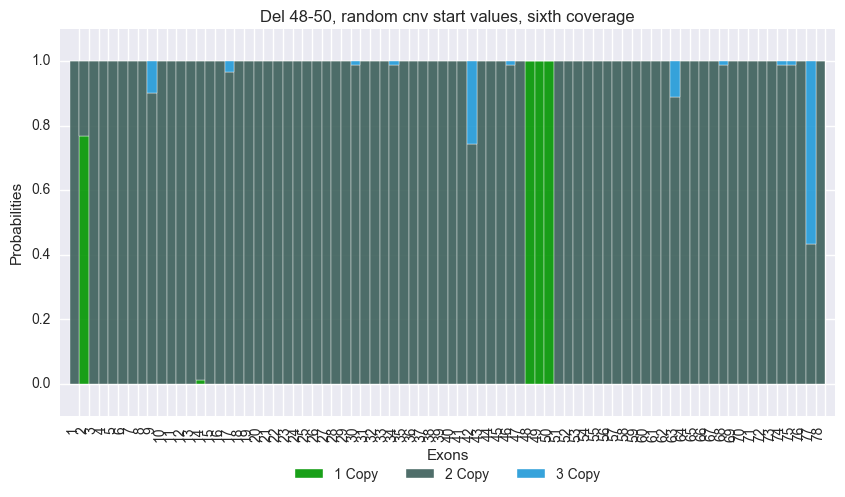

In [244]:
# note that this subject has a simulated deletion in exons 48-50 
create_stacked_bars(gibbs_df_822R4, 'Del 48-50, random cnv start values, sixth coverage')

## Results for simulated deletion (exons 16-19), subject FGPC-4ZPF-J0F1

In [303]:
cnv_support = [1,2,3]
gibbs_data_J0F1, gibbs_data_results_J0F1, logliks_J0F1, gibbs_df_J0F1 = generate_gibbs_df(cnv_support, 
                                                                        X_probs, data=subject_data_del16, 
                                                                        iterations=10000)

[3 3 3 1 1 1 1 3 2 2 3 2 3 3 3 3 3 2 3 1 3 3 1 3 3 2 3 2 1 2 1 3 1 3 3 1 2
 2 2 1 1 3 3 1 1 1 2 1 2 1 2 2 3 2 3 2 1 3 2 3 3 3 2 1 2 2 2 1 2 3 3 3 1 3
 2 3 1 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


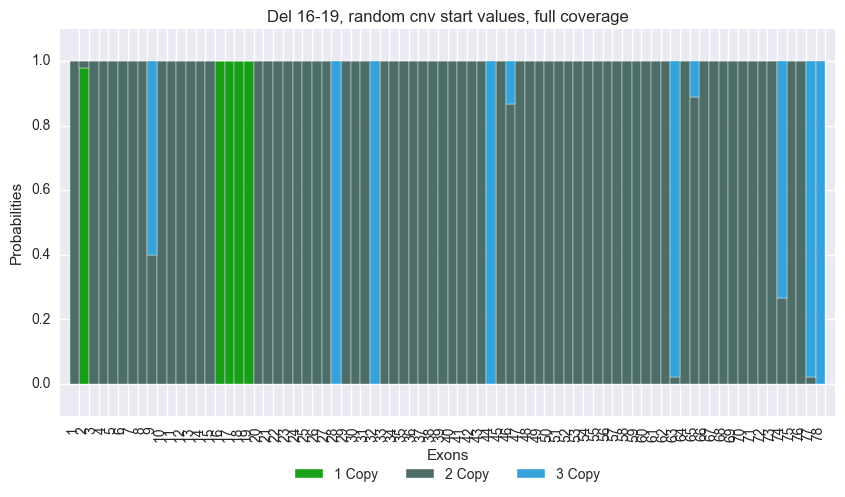

In [304]:
create_stacked_bars(gibbs_df_J0F1, 'Del 16-19, random cnv start values, full coverage')

### Comments
* Seem to have several false duplications called here
* Could some of these "duplications" resulting from a greater than expected proportion of reads in those exons be due to the lower total coverage count resulting from deleting half of the reads in exons 16-19?

## Results for simulated duplication (exon 30), subject FGPC-0000-444F

In [305]:
cnv_support = [1,2,3]
gibbs_data_444F, gibbs_data_results_444F, logliks_444F, gibbs_df_444F = generate_gibbs_df(cnv_support, 
                                                                        X_probs, data=subject_data_dup30, 
                                                                        iterations=10000)

[1 1 2 2 2 2 3 3 2 1 2 1 3 1 1 1 3 1 1 2 3 2 2 1 3 3 2 1 1 3 2 2 2 3 3 3 3
 1 2 3 1 1 2 2 3 2 2 1 1 1 2 1 3 2 2 2 1 2 2 1 3 3 3 2 2 1 2 2 2 3 2 2 1 2
 3 1 2 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


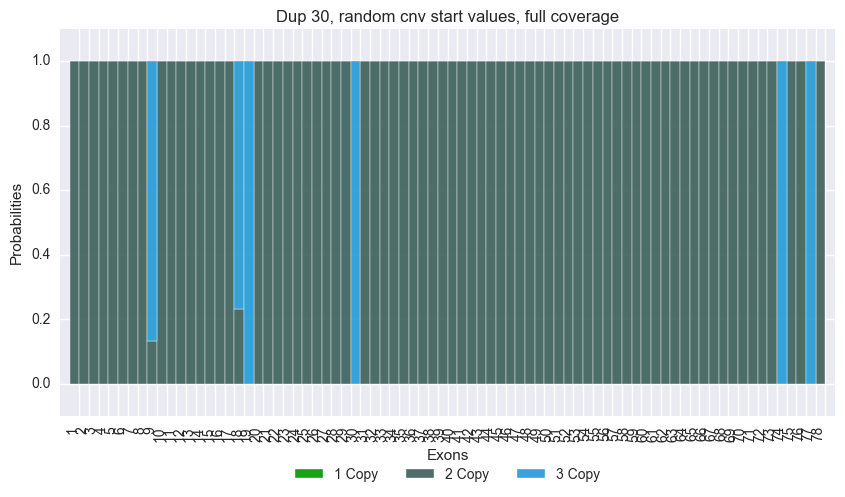

In [306]:
create_stacked_bars(gibbs_df_444F, 'Dup 30, random cnv start values, full coverage')